In [1]:
import sys
sys.path.append("../../")

from astronn.datasets import deltascuti, bedding, corot ,starmodels
from astronn import models

import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import shap
from scipy.signal import find_peaks
import pickle

import matplotlib.pyplot as plt

Using TensorFlow backend.


### The next Period-Luminosity relation is obtained by using the data provided in McNamara (2011):

$\log_{10} \text{L}_\odot = 1.4722 (0.100) \log_{10} \text{P} + 2.6089 (0.096)$

&nbsp;
&nbsp;


### Period (variable $\text{P}$) is isolated to obtained its value given the Luminosity.

$\log_{10} \text{L}_\odot - 2.6089 (0.096) = 1.4722 (0.100) \log_{10} \text{P}$

$\log_{10} \text{P} = \Large\frac{\log_{10} \text{L}_\odot - 2.6089 (0.096)}{1.4722 (0.100)}$

$\text{P} = 10\Large^{\Large\frac{\log_{10} \text{L}_\odot - 2.6089 (0.096)}{1.4722 (0.100)}}$

&nbsp;

The fundamental radial mode $\text{P}_0$ is related to the mean density by the pulsation constant $\text{Q} = \text{P} \cdot \Large\sqrt{\frac{\rho}{\rho_\odot}}$ (see Breger, 1990). For $\text{P}_0$ the value of $\text{Q} = [0.03, 0.0492] \text{ (days)}$

Thus, by isolating $\frac{\rho}{\rho_\odot}$ in the above equation and given the value of $\text{P}$, we have a direct estimation of the mean density, as follows:

&nbsp;

$\Large\frac{\rho}{\rho_\odot} = \Big( \frac{Q}{P}\Big)^2$

In [2]:
def get_log_l(P, A=1.4722, e_A=0.1, B=2.6089, e_B=0.096):
    """
    P-L relation for McNamara (2011)
    """
    return A * np.log10(P) + B


def get_P(log_L, A=1.4722, e_A=0.1, B=2.6089, e_B=0.096):
    """
    P variable isolated from log_L relation
    """
    return np.power(10, (log_L - B) / (A))

def get_rho_from_P(P, Q=0.033):
    """
    """
    return np.power(Q/P, 2)

# Example
P = 2.34
log_l = get_log_l(P=P)
P_equation = get_P(log_L=log_l)
print("P value = %f" % P)
print("log L is equal to %f" % log_l)
print("P from equation %f" % P_equation)
# Assert results
np.testing.assert_almost_equal(P, P_equation)

P value = 2.340000
log L is equal to 3.152460
P from equation 2.340000


## Relate to the error, we use a standard error propagation to calculate it:

$\Delta P = \sqrt{\Big(\frac{\delta \text{P}}{\delta \text{A}}\Delta\text{A}\Big)^2  +  \Big(\frac{\delta \text{P}}{\delta \text{B}}\Delta\text{B}\Big)^2   +    \Big(\frac{\delta \text{P}}{\delta \text{L}}\Delta\text{L}\Big)^2}$ where $A = 1.4722$ with uncertainty $\Delta A = 0.100$ and $B = 2.6089$ with uncertainty $\Delta B = 0.096$

$\Delta P = \sqrt{ \Big( 10^{\frac{\text{L}_\odot - B}{A}}  * (2.30258509 * A^2) * \text{L}_\odot * \Delta A \Big)^2 + \Big( 10^{\frac{\text{L}_\odot - B}{A}}  * (2.30258509 * A) *  \Delta B \Big)^2}$

In [3]:
def p_error(log_L, A=1.4722, e_A=0.1, B=2.6089, e_B=0.096):
    """
    """
    return np.sqrt(
        np.power(
            np.power(10, (log_L - B) / A) * (2.30258509 / np.power(A, 2)) * log_L * e_A,
            2,
        )
        + np.power(np.power(10, (log_L - B) / A) * (2.30258509 / A) * e_B, 2)
    )


l_value = 1.3
print(
    "Period for L=%f is equal to %f +-(%f)"
    % (l_value, get_P(log_L=1.3), p_error(log_L=1.3))
)

Period for L=1.300000 is equal to 0.129099 +-(0.026337)


### Relation Rodriguez-Martin et.al. 2020

$\frac{\bar{\rho}}{\rho} = 1.6^{+0.5}_{-0.4} \Big( \langle\Delta\nu\rangle / \Delta\nu_\odot \Big)^{2.02^{+0.10}_{-0.10}}$

For the moment, we will use a simetric error in the first term i.e.: $1.6^{+0.5}_{-0.5}$

$\Delta \frac{\bar{\rho}}{\rho} = \sqrt{\Big(\frac{\delta \text{P}}{\delta \text{A}}\Delta\text{A}\Big)^2  +  \Big(\frac{\delta \text{P}}{\delta \text{B}}\Delta\text{B}\Big)^2 }$ where $A = 1.6$ with uncertainty $\Delta A = 0.5$ and $B = 2.02$ with uncertainty $\Delta B = 0.1$

$\Delta \frac{\bar{\rho}}{\rho}  = \sqrt{ ( {\langle\Delta\nu\rangle / \Delta\nu_\odot} )^B * \Delta \text{A} )^2 +  (A * ( {\langle\Delta\nu\rangle / \Delta\nu_\odot} )^B + \log_{10}(x) * \Delta B)^2 }$


In [4]:
def get_rho(delta_nu):
    """
    """
    return 1.6 * np.power(delta_nu, 2.02)


def rho_error(delta_nu, A=1.6, e_A=0.5, B=2.02, e_B=0.1):
    """
    """
    return np.sqrt(
        np.power(np.power(delta_nu, B) * e_A, 2) 
        + np.power(A * np.power(delta_nu, B) * np.log10(delta_nu) * e_B, 2)
    )

delta_nu_value = 1.3
print(
    "Delta_nu == %f is a rho equal to %f +-(%f)"
    % (l_value, get_rho(delta_nu=delta_nu_value), rho_error(delta_nu=delta_nu_value))
)

Delta_nu == 1.300000 is a rho equal to 2.718226 +-(0.850010)


#### Load pre-trained NN model

In [5]:
# Load model
sepconv_mod = tf.keras.models.load_model("/home/roberto/Projects/sepconvnn_tmp_400/")
sepconv_mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv1d (SeparableC (None, 397, 10)           610       
_________________________________________________________________
batch_normalization (BatchNo (None, 397, 10)           40        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 198, 10)           0         
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 194, 10)           1510      
_________________________________________________________________
batch_normalization_1 (Batch (None, 194, 10)           40        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 97, 10)            0         
_________________________________________________________________
separable_conv1d_2 (Separabl (None, 47, 10)            1

## Read an process 11 binaries DS

##### Calculate Luminosity

In [6]:
csv_ds = pd.read_csv("../data/deltascuti/binaries_obs.csv")
print(csv_ds[["ID", "parallax", "L"]].head(11))

# 1 mas = 0.00099999995874704 arcsec
Mv = csv_ds["mv"] + 5 * (np.log10(csv_ds["parallax"] * 0.00099999995874704) + 1)
mbolsun = 4.74
# calculate Luminosity
csv_ds["L"] = (np.power(10, 0.4 * (mbolsun - Mv))) * csv_ds["L.Ltot"]

# Filter columns and add HD15082 info
csv_ds = csv_ds[["ID", "Dnu_muHz", "L", "Teff"]]
csv_ds.loc[len(csv_ds)] = ["HD15082", np.nan, 6.14, np.nan]
# Updated CID100866999 with Gaia Luminosity
csv_ds.loc[csv_ds['ID'] == "CID100866999", ['L']] = 3.3

csv_ds.head(11)

             ID  parallax   L
0    KIC3858884    1.7800 NaN
1    KIC4544587    1.3600 NaN
2   KIC10661783    1.9400 NaN
3      HD172189    2.2700 NaN
4  CID100866999    0.5654 NaN
5  CID105906206    0.9901 NaN
6      HD159561   67.1300 NaN
7    KIC9851944    0.4100 NaN
8    KIC8262223    0.9832 NaN
9   KIC10080943    1.0600 NaN


,ID,Dnu_muHz,L,Teff
0,KIC3858884,29.0,21.520774,6606.0
1,KIC4544587,74.0,6.475306,7750.0
2,KIC10661783,39.0,29.304625,7764.0
3,HD172189,19.0,29.942319,7750.0
4,CID100866999,56.0,3.300000,7300.0
5,CID105906206,20.0,9.396579,6750.0
6,HD159561,38.0,24.642612,8047.0
7,KIC9851944,26.0,60.062351,6902.0
8,KIC8262223,77.0,5.139949,9128.0
9,KIC10080943,52.0,7.085301,7480.0


In [7]:
for l_value in csv_ds["L"]:
    print(
    "Period for L=%f is equal to %f +-(%f)"
    % (l_value, get_P(log_L=np.log10(l_value)), p_error(log_L=np.log10(l_value)))
    )

Period for L=21.520774 is equal to 0.135907 +-(0.028049)
Period for L=6.475306 is equal to 0.060110 +-(0.010407)
Period for L=29.304625 is equal to 0.167616 +-(0.036273)
Period for L=29.942319 is equal to 0.170085 +-(0.036929)
Period for L=3.300000 is equal to 0.038027 +-(0.006082)
Period for L=9.396579 is equal to 0.077408 +-(0.014111)
Period for L=24.642612 is equal to 0.149005 +-(0.031399)
Period for L=60.062351 is equal to 0.272908 +-(0.065866)
Period for L=5.139949 is equal to 0.051382 +-(0.008636)
Period for L=7.085301 is equal to 0.063900 +-(0.011197)
Period for L=6.140000 is equal to 0.057977 +-(0.009967)


In [8]:
# Load Teff,Dnu -> L model from star models
with open("../models/gam_teff_dnu/gam.pkl", 'rb') as f:
    gam_teff_dnu = pickle.load(f)
gam_teff_dnu.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     84.6873
Link Function:                     IdentityLink Log Likelihood:                               -960654.4226
Number of Samples:                       494768 AIC:                                          1921480.2198
                                                AICc:                                         1921480.2499
                                                GCV:                                                2.2207
                                                Scale:                                                2.22
                                                Pseudo R-Squared:                                   0.9958
Feature Function                  Lam

In [9]:
# Load star models dataset
sm = starmodels()
sm_df = sm.load("/home/roberto/Downloads/dataall_parts/*")

dnu_sun = 134.8

# Read datasets of preprocessed stars
df_ds = deltascuti()
df = df_ds.load("../../astronn/data/deltascuti/preprocessed/*", batch_size=1)
# Read star models (trainning) to calculate shap values
star_models = starmodels()
df_sm = star_models.load(
    "/home/roberto/Downloads/dataall_parts/*", batch_size=150, add_noise=True
)
_train_shap = np.asarray([line[0].numpy() for line in df_sm.take(10)])
_train_shap = _train_shap.reshape(
    (
        _train_shap.shape[0] * _train_shap.shape[1],
        _train_shap.shape[2],
        _train_shap.shape[3],
    )
)

# Save results and predictions
results = {}
for star in df.take(11):  # take the 11 ds stars
    target = np.where(star[2].numpy().flat == 1)[0].flat[0]
    # Save results
    if star[0].numpy()[0].decode("utf-8") not in results:
        results[star[0].numpy()[0].decode("utf-8")] = {
            "inference": sepconv_mod.predict_classes(star[1]),
            "target": target,
        }

    probs = sepconv_mod.predict_proba(star[1])[0]
    peaks, _ = find_peaks(probs, height=0, distance=15)
    peaks_sorted_by_prob = np.sort(probs[peaks])[::-1]

    # save top-k
    results[star[0].numpy()[0].decode("utf-8")]["top-k1"] = np.where(
        probs == peaks_sorted_by_prob[0]
    )[0][0]
    results[star[0].numpy()[0].decode("utf-8")]["top-k2"] = np.where(
        probs == peaks_sorted_by_prob[1]
    )[0][0]
    results[star[0].numpy()[0].decode("utf-8")]["top-k3"] = np.where(
        probs == peaks_sorted_by_prob[2]
    )[0][0]
    results[star[0].numpy()[0].decode("utf-8")]["top-k4"] = np.where(
        probs == peaks_sorted_by_prob[3]
    )[0][0]
    results[star[0].numpy()[0].decode("utf-8")]["prob-topk1"] = probs[
        np.where(probs == peaks_sorted_by_prob[1])[0][0]
    ]
    results[star[0].numpy()[0].decode("utf-8")]["prob-topk2"] = probs[
        np.where(probs == peaks_sorted_by_prob[2])[0][0]
    ]
    results[star[0].numpy()[0].decode("utf-8")]["prob-topk3"] = probs[
        np.where(probs == peaks_sorted_by_prob[3])[0][0]
    ]
    results[star[0].numpy()[0].decode("utf-8")]["prob-topk4"] = probs[
        np.where(probs == peaks_sorted_by_prob[4])[0][0]
    ]

    # Get rho
    results[star[0].numpy()[0].decode("utf-8")]["rho-target"] = get_rho(
        target / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["rho-top-k1"] = get_rho(
        results[star[0].numpy()[0].decode("utf-8")]["top-k1"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["rho-top-k2"] = get_rho(
        results[star[0].numpy()[0].decode("utf-8")]["top-k2"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["rho-top-k3"] = get_rho(
        results[star[0].numpy()[0].decode("utf-8")]["top-k3"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["rho-top-k4"] = get_rho(
        results[star[0].numpy()[0].decode("utf-8")]["top-k4"] / dnu_sun
    )

    # Get errors in rho
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-target"] = rho_error(
        target / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k1"] = rho_error(
        results[star[0].numpy()[0].decode("utf-8")]["top-k1"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k2"] = rho_error(
        results[star[0].numpy()[0].decode("utf-8")]["top-k2"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k3"] = rho_error(
        results[star[0].numpy()[0].decode("utf-8")]["top-k3"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k4"] = rho_error(
        results[star[0].numpy()[0].decode("utf-8")]["top-k4"] / dnu_sun
    )

    # Get L from Teff,Dnu model
    L = csv_ds[csv_ds.ID.eq(star[0].numpy()[0].decode("utf-8").upper())]["L"].values
    Teff = csv_ds[csv_ds.ID.eq(star[0].numpy()[0].decode("utf-8").upper())]["Teff"].values
    if len(L) > 0 and not np.isnan(L) and not np.isnan(Teff):
        l_teff_topk1 = gam_teff_dnu.predict(np.asarray([results[star[0].numpy()[0].decode("utf-8")]["top-k1"], Teff]).reshape(1,2))[0]
        l_teff_topk2 = gam_teff_dnu.predict(np.asarray([results[star[0].numpy()[0].decode("utf-8")]["top-k2"], Teff]).reshape(1,2))[0]
        l_teff_topk3 = gam_teff_dnu.predict(np.asarray([results[star[0].numpy()[0].decode("utf-8")]["top-k3"], Teff]).reshape(1,2))[0]
        l_teff_topk4 = gam_teff_dnu.predict(np.asarray([results[star[0].numpy()[0].decode("utf-8")]["top-k4"], Teff]).reshape(1,2))[0]

        # Get L errors
        ls_teff_topks = [l_teff_topk1, l_teff_topk2, l_teff_topk3, l_teff_topk4]
        # Get L errors
        errors = [
                round(np.power(l_teff_topk1 - L[0], 2), 2),
                round(np.power(l_teff_topk2 - L[0], 2), 2),
                round(np.power(l_teff_topk3 - L[0], 2), 2),
                round(np.power(l_teff_topk4 - L[0], 2), 2),
            ]
        i = np.argmin(errors) # Get min error position
        L = ls_teff_topks[i] # Get most probable L from the model

        P = get_P(np.log10(L))
        p_e = p_error(log_L=np.log10(L))
        rho_q_up = get_rho_from_P(P-p_e, Q=0.033)
        rho_q_down = get_rho_from_P(P+p_e, Q=0.042)
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-up-fromstarmodel"] = rho_q_up
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-down-fromstarmodel"] = rho_q_down
    else:
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-up-fromstarmodel"] = np.nan
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-down-fromstarmodel"] = np.nan


    # Get P from L
    # Check for non L in csv or NaN value
    L = csv_ds[csv_ds.ID.eq(star[0].numpy()[0].decode("utf-8").upper())]["L"].values
    if len(L) > 0 and not np.isnan(L):
        P = get_P(np.log10(L))
        p_e = p_error(log_L=np.log10(L))
        rho_q_up = get_rho_from_P(P-p_e, Q=0.033)
        rho_q_down = get_rho_from_P(P+p_e, Q=0.042)
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-up"] = rho_q_up[0]
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-down"] = rho_q_down[0]
    else:
        print(star[0].numpy()[0].decode("utf-8"))
        print(L)
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-up"] = np.nan
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-down"] = np.nan


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Instructions for updating:
Please use `model.predict()` instead.


In [10]:
df = pd.DataFrame(
    columns=[
        "id",
        "rho-target",
        "e-rho-target",
        "rho-from-P-up-fromstarmodel",
        "rho-from-P-down-fromstarmodel",
        "rho-top-k1",
        "e-rho-top-k1",
        "rho-top-k2",
        "e-rho-top-k2",
        "rho-top-k3",
        "e-rho-top-k3",
        "rho-top-k4",
        "e-rho-top-k4",
        "rho-from-P-up",
        "rho-from-P-down",

    ]
)
for i, id in enumerate(results):
    df.loc[i] = [
        id,
        results[id]["rho-target"],
        results[id]["e-rho-target"],
        results[id]["rho-from-P-up-fromstarmodel"],
        results[id]["rho-from-P-down-fromstarmodel"],
        results[id]["rho-top-k1"],
        results[id]["e-rho-top-k1"],
        results[id]["rho-top-k2"],
        results[id]["e-rho-top-k2"],
        results[id]["rho-top-k3"],
        results[id]["e-rho-top-k3"],
        results[id]["rho-top-k4"],
        results[id]["e-rho-top-k4"],
        results[id]["rho-from-P-up"],
        results[id]["rho-from-P-down"],
    ]
df

,id,rho-target,e-rho-target,rho-from-P-up-fromstarmodel,rho-from-P-down-fromstarmodel,rho-top-k1,e-rho-top-k1,rho-top-k2,e-rho-top-k2,rho-top-k3,e-rho-top-k3,rho-top-k4,e-rho-top-k4,rho-from-P-up,rho-from-P-down
0,HD172189,0.030565,0.009899,0.043424,0.027990,0.044961,0.014468,0.130646,0.041429,0.000734,0.000260,0.344203,0.108163,0.061420,0.041162
1,kic4544587,0.476425,0.149399,0.328604,0.258594,0.104994,0.033382,0.030565,0.009899,0.502794,0.157621,0.252105,0.079417,0.440822,0.354750
2,CID105906206,0.033902,0.010961,0.353564,0.279843,0.041100,0.013245,0.117466,0.037296,0.252105,0.079417,0.001313,0.000457,0.271805,0.210611
3,KIC9851944,0.057596,0.018463,0.037300,0.023623,0.087609,0.027919,0.261625,0.082390,0.021601,0.007040,0.000080,0.000030,0.025405,0.015370
4,CID100866999,0.271323,0.085418,0.389043,0.310194,0.224615,0.070830,0.037414,0.012076,0.676085,0.211647,0.401619,0.126072,1.067122,0.906660
5,KIC3858884,0.071811,0.022947,0.094360,0.066201,0.044961,0.014468,0.252105,0.079417,0.123968,0.039335,0.630337,0.197384,0.093611,0.065621
6,HD159561,0.123968,0.039335,0.071162,0.048461,0.117466,0.037296,0.041100,0.013245,0.502794,0.157621,0.261625,0.082390,0.078735,0.054201
7,KIC8262223,0.516247,0.161815,0.091808,0.064228,0.041100,0.013245,0.117466,0.037296,0.322487,0.101387,0.000734,0.000260,0.595984,0.489701
8,KIC10080943,0.233600,0.073637,0.399509,0.319175,0.071811,0.022947,0.252105,0.079417,0.014201,0.004666,0.502794,0.157621,0.392068,0.312788
9,HD15082,0.557684,0.174734,NaN,NaN,0.707483,0.221437,0.463509,0.145372,0.215807,0.068077,0.000734,0.000260,0.472460,0.382110


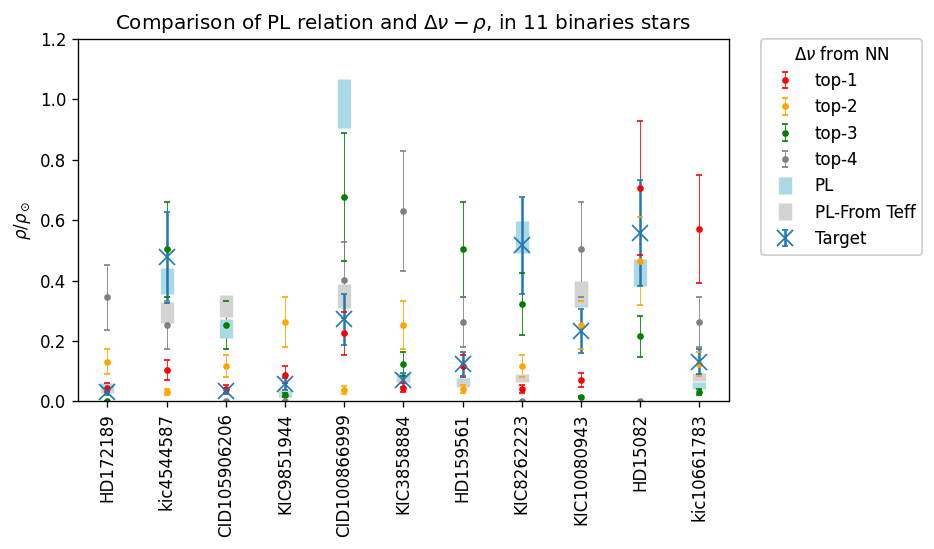

In [11]:
plt.subplots(1, figsize=(7, 4), dpi=120)

p1,p1,p1 = plt.errorbar(
    df["id"],
    df["rho-top-k1"],
    df["e-rho-top-k1"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="red",
    label="top-1",
)
p2,_,_ = plt.errorbar(
    df["id"],
    df["rho-top-k2"],
    df["e-rho-top-k2"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="orange",
    label="top-2",
)
p3,_,_ = plt.errorbar(
    df["id"],
    df["rho-top-k3"],
    df["e-rho-top-k3"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="green",
    label="top-3",
)
p4,_,_ = plt.errorbar(
    df["id"],
    df["rho-top-k4"],
    df["e-rho-top-k4"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="grey",
    label="top-4",
)
p5,_,_ = plt.errorbar(
    df["id"],
    (df["rho-from-P-up"] + df["rho-from-P-down"]) / 2,
    df["rho-from-P-up"] - ((df["rho-from-P-up"] + df["rho-from-P-down"]) / 2),
    elinewidth=8,
    fmt="o",
    markersize=0,
    capsize=0,
    label="PL",
    color="lightblue",
)

plt.errorbar(
    df["id"],
    (df["rho-from-P-up-fromstarmodel"] + df["rho-from-P-down-fromstarmodel"]) / 2,
    df["rho-from-P-up-fromstarmodel"] - ((df["rho-from-P-up-fromstarmodel"] + df["rho-from-P-down-fromstarmodel"]) / 2),
    elinewidth=8,
    fmt="o",
    markersize=0,
    capsize=0,
    label="PL-From Teff",
    color="lightgrey",
)

p6,_,_ = plt.errorbar(
    df["id"],
    df["rho-target"],
    df["e-rho-target"],
    fmt="x",
    markersize=10,
    capsize=2,
    label="Target",
)
plt.xticks(rotation=90)

legend1 = plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.0,
    title=r"$\Delta\nu$ from NN",
)
plt.gca().add_artist(legend1)

plt.ylabel("$\\rho / \\rho_\\odot$")
plt.title("Comparison of PL relation and $\Delta\\nu-\\rho$, in 11 binaries stars")
plt.ylim(0, 1.2)
plt.show()

#### calculate errors and best top-k

In [12]:
results_binaries = pd.DataFrame(
    columns=[
        "id",
        "rho-target",
        "e-rho-target",
        "rho-from-P",
        "e-rho-from-P",
        "best-top",
        "e-best-top",
        "ktop",
    ]
)

for index, row in df.iterrows():
    print("Proccessing star %s" % row["id"])
    print("PL[%f,%f]" % (row["rho-from-P-up"], row["rho-from-P-down"]))
    top_indexs = ["rho-top-k1", "rho-top-k2", "rho-top-k3", "rho-top-k4"]

    best = np.nan
    print("%f-%f" % (row["rho-from-P-up"], row["rho-from-P-down"]))
    for top_index in top_indexs:
        top_up = row[top_index] + row["e-%s" % top_index]
        top_down = row[top_index] - row["e-%s" % top_index]
        print("[%f  -  %f]" % (top_up, top_down))
        if (top_up <= row["rho-from-P-up"] and top_up >= row["rho-from-P-down"]) or (
            top_down <= row["rho-from-P-up"] and top_down >= row["rho-from-P-down"]) or(
            top_down <= row["rho-from-P-down"] and top_up >= row["rho-from-P-up"]    
            ):
            print(" * %s is the PL-rho range" % top_index)
            if np.isnan(best):
                print("   => Saving most probabily rho of NN: %f" % row[top_index])
                best = row[top_index]
                results_binaries.loc[len(results_binaries)] = [
                    row["id"],
                    row["rho-target"],
                    row["e-rho-target"],
                    (row["rho-from-P-up"] + row["rho-from-P-down"]) / 2,
                    row["rho-from-P-up"] - ((row["rho-from-P-up"] + row["rho-from-P-down"]) / 2),
                    row[top_index],
                    row["e-%s" % top_index],
                    top_index.split("-")[2]
                ]
        

results_binaries

Proccessing star HD172189
PL[0.061420,0.041162]
0.061420-0.041162
[0.059429  -  0.030493]
 * rho-top-k1 is the PL-rho range
   => Saving most probabily rho of NN: 0.044961
[0.172075  -  0.089217]
[0.000994  -  0.000475]
[0.452365  -  0.236040]
Proccessing star kic4544587
PL[0.440822,0.354750]
0.440822-0.354750
[0.138376  -  0.071612]
[0.040465  -  0.020666]
[0.660414  -  0.345173]
 * rho-top-k3 is the PL-rho range
   => Saving most probabily rho of NN: 0.502794
[0.331522  -  0.172688]
Proccessing star CID105906206
PL[0.271805,0.210611]
0.271805-0.210611
[0.054345  -  0.027855]
[0.154763  -  0.080170]
[0.331522  -  0.172688]
 * rho-top-k3 is the PL-rho range
   => Saving most probabily rho of NN: 0.252105
[0.001770  -  0.000856]
Proccessing star KIC9851944
PL[0.025405,0.015370]
0.025405-0.015370
[0.115528  -  0.059690]
[0.344015  -  0.179235]
[0.028641  -  0.014561]
 * rho-top-k3 is the PL-rho range
   => Saving most probabily rho of NN: 0.021601
[0.000110  -  0.000050]
Proccessing star

,id,rho-target,e-rho-target,rho-from-P,e-rho-from-P,best-top,e-best-top,ktop
0,HD172189,0.030565,0.009899,0.051291,0.010129,0.044961,0.014468,k1
1,kic4544587,0.476425,0.149399,0.397786,0.043036,0.502794,0.157621,k3
2,CID105906206,0.033902,0.010961,0.241208,0.030597,0.252105,0.079417,k3
3,KIC9851944,0.057596,0.018463,0.020387,0.005017,0.021601,0.007040,k3
4,KIC3858884,0.071811,0.022947,0.079616,0.013995,0.123968,0.039335,k3
5,HD159561,0.123968,0.039335,0.066468,0.012267,0.041100,0.013245,k2
6,KIC10080943,0.233600,0.073637,0.352428,0.039640,0.252105,0.079417,k2
7,HD15082,0.557684,0.174734,0.427285,0.045175,0.463509,0.145372,k2


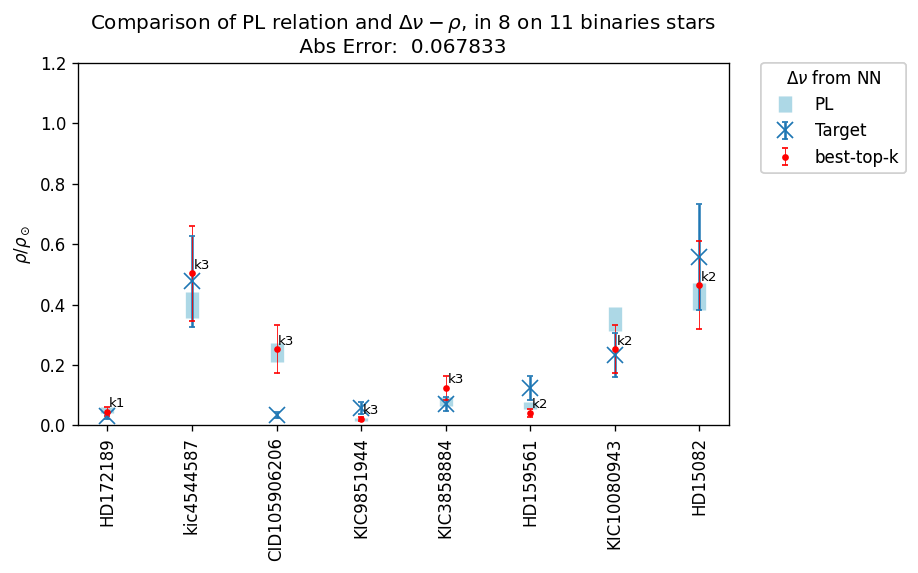

In [13]:
plt.subplots(1, figsize=(7, 4), dpi=120)
plt.errorbar(
    results_binaries["id"],
    results_binaries["rho-from-P"],
    results_binaries["e-rho-from-P"],
    elinewidth=8,
    fmt="o",
    markersize=0,
    capsize=0,
    label="PL",
    color="lightblue",
)
plt.errorbar(
    results_binaries["id"],
    results_binaries["rho-target"],
    results_binaries["e-rho-target"],
    fmt="x",
    markersize=10,
    capsize=2,
    label="Target"
)
plt.errorbar(
    results_binaries["id"],
    results_binaries["best-top"],
    results_binaries["e-best-top"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="red",
    label="best-top-k",
)
for xpos, ypos, name in zip(results_binaries["id"], results_binaries["best-top"], results_binaries["ktop"]):
    plt.annotate(name, (xpos, ypos), xytext=(1, 1), va='bottom', textcoords='offset points', size=8)

plt.xticks(rotation=90)

legend1 = plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.0,
    title=r"$\Delta\nu$ from NN",
)
plt.gca().add_artist(legend1)

binaries_abs_error = np.mean(np.abs(results_binaries["rho-target"] - results_binaries["best-top"]))
plt.ylabel("$\\rho / \\rho_\\odot$")
plt.title("Comparison of PL relation and $\Delta\\nu-\\rho$, in %d on 11 binaries stars\n Abs Error:  %f " % (len(results_binaries), binaries_abs_error))

plt.ylim(0, 1.2)
plt.show()

## Read and process Bedding stars 

In [14]:
# Read datasets of preprocessed stars
bedding_stars = bedding()
df_bedding = bedding_stars.load("../data/bedding/preprocessed/*", batch_size=1)

#### Read L from file

In [15]:
df_att = pd.io.parsers.read_csv("../data/bedding/bedding.csv", sep=",", index_col=0)
df_att

,HD,Name,TIC,V,Teff,L,e.L.,rho,e.rho.,Dnu,eps,vsini,e.vsini.,F0
1,2280.0,NaN,281499618,9.13,7510.0,5.52,0.26,0.49,0.06,7.17,1.73,26.4,1.3,19.5741
2,3622.0,NaN,43363194,7.77,7930.0,7.86,0.35,0.45,0.06,6.89,1.61,50.0,6.0,17.9829
3,10779.0,NaN,229139161,8.78,7730.0,8.13,0.36,0.39,0.05,6.80,1.63,91.0,5.0,17.8840
4,10961.0,NaN,231014033,9.39,7430.0,NaN,NaN,NaN,NaN,7.30,1.70,33.0,3.0,19.7100
5,17341.0,NaN,122615966,9.32,7810.0,10.05,0.50,0.32,0.05,5.90,1.73,14.0,1.0,16.1070
6,17693.0,NaN,122686610,7.80,7880.0,10.21,0.44,0.33,0.04,6.41,1.61,NaN,NaN,16.7301
7,20203.0,NaN,274038922,8.85,7970.0,8.06,0.38,0.45,0.05,7.20,1.76,40.0,25.0,19.8720
8,20232.0,NaN,159895674,6.88,8060.0,8.64,0.36,0.44,0.05,6.86,1.64,37.0,3.0,18.1104
9,24572.0,NaN,242944780,9.45,7410.0,7.25,0.36,0.35,0.05,7.20,1.58,NaN,NaN,18.5760
10,24975.0,NaN,44645679,7.24,7790.0,9.20,0.39,0.35,0.04,6.23,1.58,88.0,4.0,16.0734


In [16]:
# Save results and predictions
results = {}
for star in df_bedding.take(57):  # take the stars
    target = np.where(star[2].numpy().flat == 1)[0].flat[0] / 0.0864
    # Save results
    if star[0].numpy()[0].decode("utf-8") not in results:
        results[star[0].numpy()[0].decode("utf-8")] = {
            "inference": sepconv_mod.predict_classes(star[1]),
            "target": target,
        }

    probs = sepconv_mod.predict_proba(star[1])[0]
    peaks, _ = find_peaks(probs, height=0, distance=15)
    peaks_sorted_by_prob = np.sort(probs[peaks])[::-1]

    # save top-k
    results[star[0].numpy()[0].decode("utf-8")]["top-k1"] = np.where(
        probs == peaks_sorted_by_prob[0]
    )[0][0]
    results[star[0].numpy()[0].decode("utf-8")]["top-k2"] = np.where(
        probs == peaks_sorted_by_prob[1]
    )[0][0]
    results[star[0].numpy()[0].decode("utf-8")]["top-k3"] = np.where(
        probs == peaks_sorted_by_prob[2]
    )[0][0]
    results[star[0].numpy()[0].decode("utf-8")]["top-k4"] = np.where(
        probs == peaks_sorted_by_prob[3]
    )[0][0]
    results[star[0].numpy()[0].decode("utf-8")]["prob-topk1"] = probs[
        np.where(probs == peaks_sorted_by_prob[0])[0][0]
    ]
    results[star[0].numpy()[0].decode("utf-8")]["prob-topk2"] = probs[
        np.where(probs == peaks_sorted_by_prob[1])[0][0]
    ]
    results[star[0].numpy()[0].decode("utf-8")]["prob-topk3"] = probs[
        np.where(probs == peaks_sorted_by_prob[2])[0][0]
    ]
    results[star[0].numpy()[0].decode("utf-8")]["prob-topk4"] = probs[
        np.where(probs == peaks_sorted_by_prob[3])[0][0]
    ]

    # Get rho
    results[star[0].numpy()[0].decode("utf-8")]["rho-target"] = get_rho(
        target / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["rho-top-k1"] = get_rho(
        results[star[0].numpy()[0].decode("utf-8")]["top-k1"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["rho-top-k2"] = get_rho(
        results[star[0].numpy()[0].decode("utf-8")]["top-k2"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["rho-top-k3"] = get_rho(
        results[star[0].numpy()[0].decode("utf-8")]["top-k3"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["rho-top-k4"] = get_rho(
        results[star[0].numpy()[0].decode("utf-8")]["top-k4"] / dnu_sun
    )

    # Get errors in rho
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-target"] = rho_error(
        target / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k1"] = rho_error(
        results[star[0].numpy()[0].decode("utf-8")]["top-k1"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k2"] = rho_error(
        results[star[0].numpy()[0].decode("utf-8")]["top-k2"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k3"] = rho_error(
        results[star[0].numpy()[0].decode("utf-8")]["top-k3"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k4"] = rho_error(
        results[star[0].numpy()[0].decode("utf-8")]["top-k4"] / dnu_sun
    )


    # Get L from Teff,Dnu model
    L = df_att[df_att.TIC.eq(str(int(star[0].numpy()[0].decode("utf-8").split("-")[2])))]["L"].values
    Teff = df_att[df_att.TIC.eq(str(int(star[0].numpy()[0].decode("utf-8").split("-")[2])))]["Teff"].values
    if len(Teff) > 0 and not np.isnan(Teff):
        gam_teff_dnu.predict(np.asarray([results[star[0].numpy()[0].decode("utf-8")]["top-k1"] / dnu_sun, Teff]).reshape(1,2))[0]
        gam_teff_dnu.predict(np.asarray([results[star[0].numpy()[0].decode("utf-8")]["top-k2"] / dnu_sun, Teff]).reshape(1,2))[0]
        gam_teff_dnu.predict(np.asarray([results[star[0].numpy()[0].decode("utf-8")]["top-k3"] / dnu_sun, Teff]).reshape(1,2))[0]
        gam_teff_dnu.predict(np.asarray([results[star[0].numpy()[0].decode("utf-8")]["top-k4"] / dnu_sun, Teff]).reshape(1,2))[0]

        # Get L errors
        ls_teff_topks = [l_teff_topk1, l_teff_topk2, l_teff_topk3, l_teff_topk4]
        # Get L errors
        errors = [
                round(np.power(l_teff_topk1 - L[0], 2), 2),
                round(np.power(l_teff_topk2 - L[0], 2), 2),
                round(np.power(l_teff_topk3 - L[0], 2), 2),
                round(np.power(l_teff_topk4 - L[0], 2), 2),
            ]
        i = np.argmin(errors) # Get min error position
        L = ls_teff_topks[i] # Get most probable L from the model

        P = get_P(np.log10(L))
        p_e = p_error(log_L=np.log10(L))
        rho_q_up = get_rho_from_P(P-p_e, Q=0.033)
        rho_q_down = get_rho_from_P(P+p_e, Q=0.042)

        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-up-fromstarmodel"] = rho_q_up
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-down-fromstarmodel"] = rho_q_down
    else:
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-up-fromstarmodel"] = np.nan
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-down-fromstarmodel"] = np.nan

    # Get P from L
    L = df_att[df_att.TIC.eq(str(int(star[0].numpy()[0].decode("utf-8").split("-")[2])))]["L"].values

    # Check for non L in csv or NaN value
    if len(L) > 0 and not np.isnan(L):
        P = get_P(np.log10(L[0]))
        p_e = p_error(log_L=np.log10(L[0]))
        #p_e=0

        rho_q_up = get_rho_from_P(P-p_e, Q=0.033)
        rho_q_down = get_rho_from_P(P+p_e, Q=0.042)
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-up"] = rho_q_up
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-down"] = rho_q_down
    else:
        print(star[0].numpy()[0].decode("utf-8"))
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-up"] = np.nan
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-down"] = np.nan

    rho_from_file = df_att[df_att.TIC.eq(str(int(star[0].numpy()[0].decode("utf-8").split("-")[2])))]["rho"].values
    results[star[0].numpy()[0].decode("utf-8")]["rho-from-file"] = rho_from_file[0]

tess2019032160000-s0008-0000000176400189-0136-s_lc_det
tess2018234235059-s0002-0000000327996759-0121-s_lc_det
tess2018319095959-s0005-0000000009147509-0125-s_lc_det
tess2018234235059-s0002-0000000316806320-0121-s_lc_det
tess2018319095959-s0005-0000000459942890-0125-s_lc_det
tess2019169103026-s0013-0000000269792989-0146-s_lc_det
tess2019058134432-s0009-0000000463556278-0139-s_lc_det
tess2018319095959-s0005-0000000306773428-0125-s_lc_det
tess2019058134432-s0009-0000000388351327-0139-s_lc_det
tess2018263035959-s0003-0000000231014033-0123-s_lc_det
tess2018319095959-s0005-0000000024344701-0125-s_lc_det


In [17]:
df = pd.DataFrame(
    columns=[
        "id",
        "rho-target",
        "e-rho-target",
        "rho-from-P-up-fromstarmodel",
        "rho-from-P-down-fromstarmodel",
        "rho-top-k1",
        "e-rho-top-k1",
        "rho-top-k2",
        "e-rho-top-k2",
        "rho-top-k3",
        "e-rho-top-k3",
        "rho-top-k4",
        "e-rho-top-k4",
        "rho-from-P-up",
        "rho-from-P-down",

    ]
)
for i, id in enumerate(results):
    df.loc[i] = [
        id,
        results[id]["rho-target"],
        results[id]["e-rho-target"],
        results[id]["rho-from-P-up-fromstarmodel"],
        results[id]["rho-from-P-down-fromstarmodel"],
        results[id]["rho-top-k1"],
        results[id]["e-rho-top-k1"],
        results[id]["rho-top-k2"],
        results[id]["e-rho-top-k2"],
        results[id]["rho-top-k3"],
        results[id]["e-rho-top-k3"],
        results[id]["rho-top-k4"],
        results[id]["e-rho-top-k4"],
        results[id]["rho-from-P-up"],
        results[id]["rho-from-P-down"],
    ]
df

,id,rho-target,e-rho-target,rho-from-P-up-fromstarmodel,rho-from-P-down-fromstarmodel,rho-top-k1,e-rho-top-k1,rho-top-k2,e-rho-top-k2,rho-top-k3,e-rho-top-k3,rho-top-k4,e-rho-top-k4,rho-from-P-up,rho-from-P-down
0,tess2019032160000-s0008-0000000176400189-0136-...,0.419039,0.131505,NaN,NaN,0.586206,0.183626,0.378116,0.118742,0.215807,0.068077,0.018961,0.006195,NaN,NaN
1,tess2018349182459-s0006-0000000408906554-0126-...,0.572119,0.179234,0.277769,0.215622,0.516247,0.161815,0.123968,0.039335,0.252105,0.079417,0.041100,0.013245,0.298100,0.232755
2,tess2018319095959-s0005-0000000000589826-0125-...,0.419039,0.131505,0.277769,0.215622,0.117466,0.037296,0.037414,0.012076,0.463509,0.145372,0.261625,0.082390,0.313334,0.245641
3,tess2018234235059-s0002-0000000327996759-0121-...,0.419039,0.131505,NaN,NaN,0.723452,0.226416,0.166694,0.052719,0.450773,0.141401,0.004067,0.001374,NaN,NaN
4,tess2019058134432-s0009-0000000260161111-0139-...,0.572119,0.179234,0.277769,0.215622,0.151743,0.048039,0.615447,0.192742,0.366633,0.115160,0.030565,0.009899,0.274319,0.212722
5,tess2018263035959-s0003-0000000122686610-0123-...,0.419039,0.131505,0.277769,0.215622,0.476425,0.149399,0.772440,0.241690,0.291253,0.091640,0.012081,0.003983,0.244126,0.187449
6,tess2018319095959-s0005-0000000431695696-0125-...,0.572119,0.179234,0.277769,0.215622,0.600737,0.188156,0.144534,0.045781,0.281199,0.088501,0.021601,0.007040,0.293742,0.229076
7,tess2018319095959-s0005-0000000143381070-0125-...,0.572119,0.179234,0.277769,0.215622,0.291253,0.091640,0.676085,0.211647,0.137502,0.043577,0.012081,0.003983,0.341477,0.269542
8,tess2018234235059-s0002-0000000229139161-0121-...,0.419039,0.131505,0.277769,0.215622,0.104994,0.033382,0.033902,0.010961,0.224615,0.070830,0.378116,0.118742,0.327910,0.258005
9,tess2019006130736-s0007-0000000112484997-0131-...,0.419039,0.131505,0.277769,0.215622,0.438216,0.137485,0.099022,0.031506,0.215807,0.068077,0.030565,0.009899,0.331611,0.261149


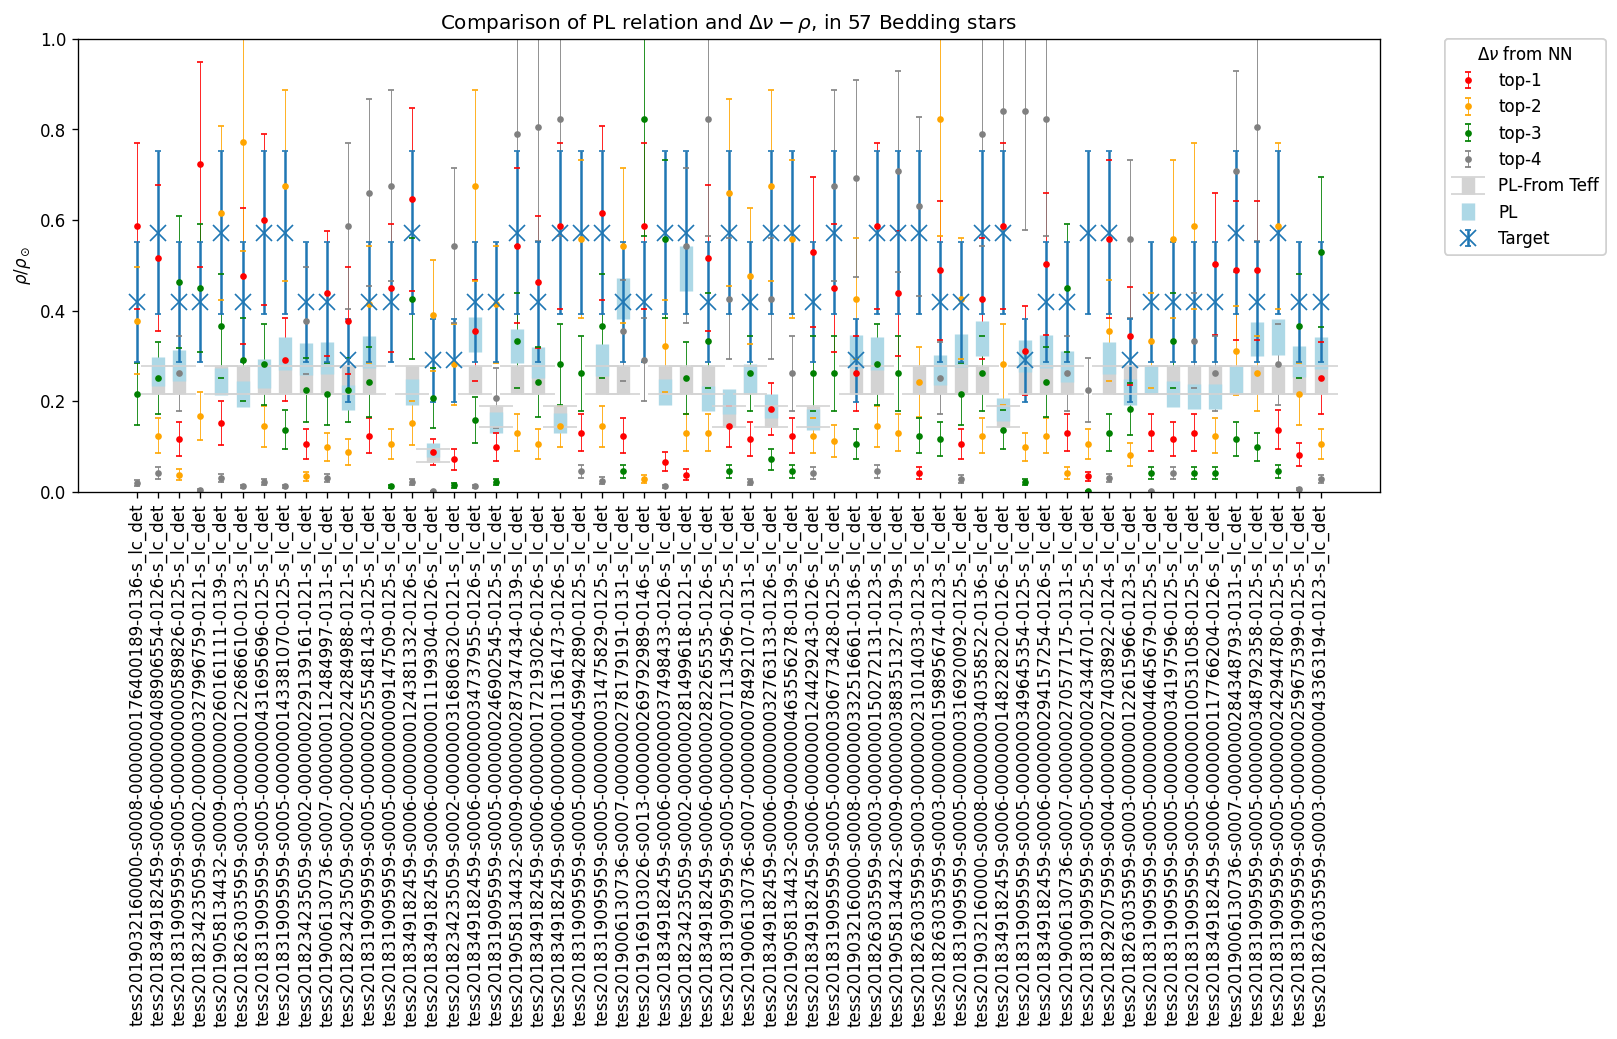

57


In [18]:
plt.subplots(1, figsize=(14, 5), dpi=120)

#plt.scatter(df["id"], df["rho-from-file"], color="black", label="rho Bedding", s=90)

p1,p1,p1 = plt.errorbar(
    df["id"],
    df["rho-top-k1"],
    df["e-rho-top-k1"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="red",
    label="top-1",
)
p2,_,_ = plt.errorbar(
    df["id"],
    df["rho-top-k2"],
    df["e-rho-top-k2"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="orange",
    label="top-2",
)
p3,_,_ = plt.errorbar(
    df["id"],
    df["rho-top-k3"],
    df["e-rho-top-k3"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="green",
    label="top-3",
)
p4,_,_ = plt.errorbar(
    df["id"],
    df["rho-top-k4"],
    df["e-rho-top-k4"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="grey",
    label="top-4",
)
plt.errorbar(
    df["id"],
    (df["rho-from-P-up-fromstarmodel"] + df["rho-from-P-down-fromstarmodel"]) / 2,
    df["rho-from-P-up-fromstarmodel"] - ((df["rho-from-P-up-fromstarmodel"] + df["rho-from-P-down-fromstarmodel"]) / 2),
    elinewidth=8,
    fmt="o",
    markersize=0,
    capsize=10,
    label="PL-From Teff",
    color="lightgrey",
)
p5,_,_ = plt.errorbar(
    df["id"],
    (df["rho-from-P-up"] + df["rho-from-P-down"]) / 2,
    df["rho-from-P-up"] - ((df["rho-from-P-up"] + df["rho-from-P-down"]) / 2),
    elinewidth=8,
    fmt="o",
    markersize=0,
    capsize=0,
    label="PL",
    color="lightblue",
)
p6,_,_ = plt.errorbar(
    df["id"],
    df["rho-target"],
    df["e-rho-target"],
    fmt="x",
    markersize=10,
    capsize=2,
    label="Target",
)

plt.xticks(rotation=90)

legend1 = plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.0,
    title=r"$\Delta\nu$ from NN",
)
plt.gca().add_artist(legend1)

plt.ylabel("$\\rho / \\rho_\\odot$")
plt.title("Comparison of PL relation and $\Delta\\nu-\\rho$, in 57 Bedding stars")
plt.ylim(0, 1.0)
plt.show()

print(len(df.index))

In [19]:
results_bedding = pd.DataFrame(
    columns=[
        "id",
        "rho-target",
        "e-rho-target",
        "rho-from-P",
        "e-rho-from-P",
        "best-top",
        "e-best-top",
        "ktop",
    ]
)

top_indexs = ["rho-top-k1", "rho-top-k2", "rho-top-k3", "rho-top-k4"]
for index, row in df.iterrows():
    print("Proccessing star %s" % row["id"])
    print("PL[%f,%f]" % (row["rho-from-P-up"], row["rho-from-P-down"]))
    best = np.nan
    for top_index in top_indexs:
        top_up = row[top_index] + row["e-%s" % top_index]
        top_down = row[top_index] - row["e-%s" % top_index]
        if (top_up <= row["rho-from-P-up"] and top_up >= row["rho-from-P-down"]) or (
            top_down <= row["rho-from-P-up"] and top_down >= row["rho-from-P-down"]) or(
            top_down <= row["rho-from-P-down"] and top_up >= row["rho-from-P-up"]    
            ):
            print(" * %s is the PL-rho range" % top_index)
            if np.isnan(best):
                print("   => Saving most probabily rho of NN: %f" % row[top_index])
                best = row[top_index]
                results_bedding.loc[len(results_bedding)] = [
                    row["id"],
                    row["rho-target"],
                    row["e-rho-target"],
                    (row["rho-from-P-up"] + row["rho-from-P-down"]) / 2,
                    row["rho-from-P-up"] - ((row["rho-from-P-up"] + row["rho-from-P-down"]) / 2),
                    row[top_index],
                    row["e-%s" % top_index],
                    top_index.split("-")[2]
                ]
    #if np.isnan(best):
    if False:
        print("not match!")
        print((top_up <= row["rho-from-P-up"] and top_up >= row["rho-from-P-down"]))
        print((top_down <= row["rho-from-P-up"] and top_down >= row["rho-from-P-down"]))
        print(row[top_index])
        print(top_up)
        print(top_down)
        top_index="rho-top-k1"
        top_up = row[top_index] + row["e-%s" % top_index]
        top_down = row[top_index] - row["e-%s" % top_index]
        if True:
            if np.isnan(best):
                print("   => Saving by-default rho of NN: %f" % row[top_index])
                best = row[top_index]
                results_bedding.loc[len(results_bedding)] = [
                    row["id"],
                    row["rho-target"],
                    row["e-rho-target"],
                    (row["rho-from-P-up"] + row["rho-from-P-down"]) / 2,
                    row["rho-from-P-up"] - ((row["rho-from-P-up"] + row["rho-from-P-down"]) / 2),
                    row[top_index],
                    row["e-%s" % top_index],
                    top_index.split("-")[2]
                ]

results_bedding
print(len(results_bedding))

Proccessing star tess2019032160000-s0008-0000000176400189-0136-s_lc_det
PL[nan,nan]
Proccessing star tess2018349182459-s0006-0000000408906554-0126-s_lc_det
PL[0.298100,0.232755]
 * rho-top-k3 is the PL-rho range
   => Saving most probabily rho of NN: 0.252105
Proccessing star tess2018319095959-s0005-0000000000589826-0125-s_lc_det
PL[0.313334,0.245641]
 * rho-top-k4 is the PL-rho range
   => Saving most probabily rho of NN: 0.261625
Proccessing star tess2018234235059-s0002-0000000327996759-0121-s_lc_det
PL[nan,nan]
Proccessing star tess2019058134432-s0009-0000000260161111-0139-s_lc_det
PL[0.274319,0.212722]
 * rho-top-k3 is the PL-rho range
   => Saving most probabily rho of NN: 0.366633
Proccessing star tess2018263035959-s0003-0000000122686610-0123-s_lc_det
PL[0.244126,0.187449]
 * rho-top-k3 is the PL-rho range
   => Saving most probabily rho of NN: 0.291253
Proccessing star tess2018319095959-s0005-0000000431695696-0125-s_lc_det
PL[0.293742,0.229076]
 * rho-top-k3 is the PL-rho range


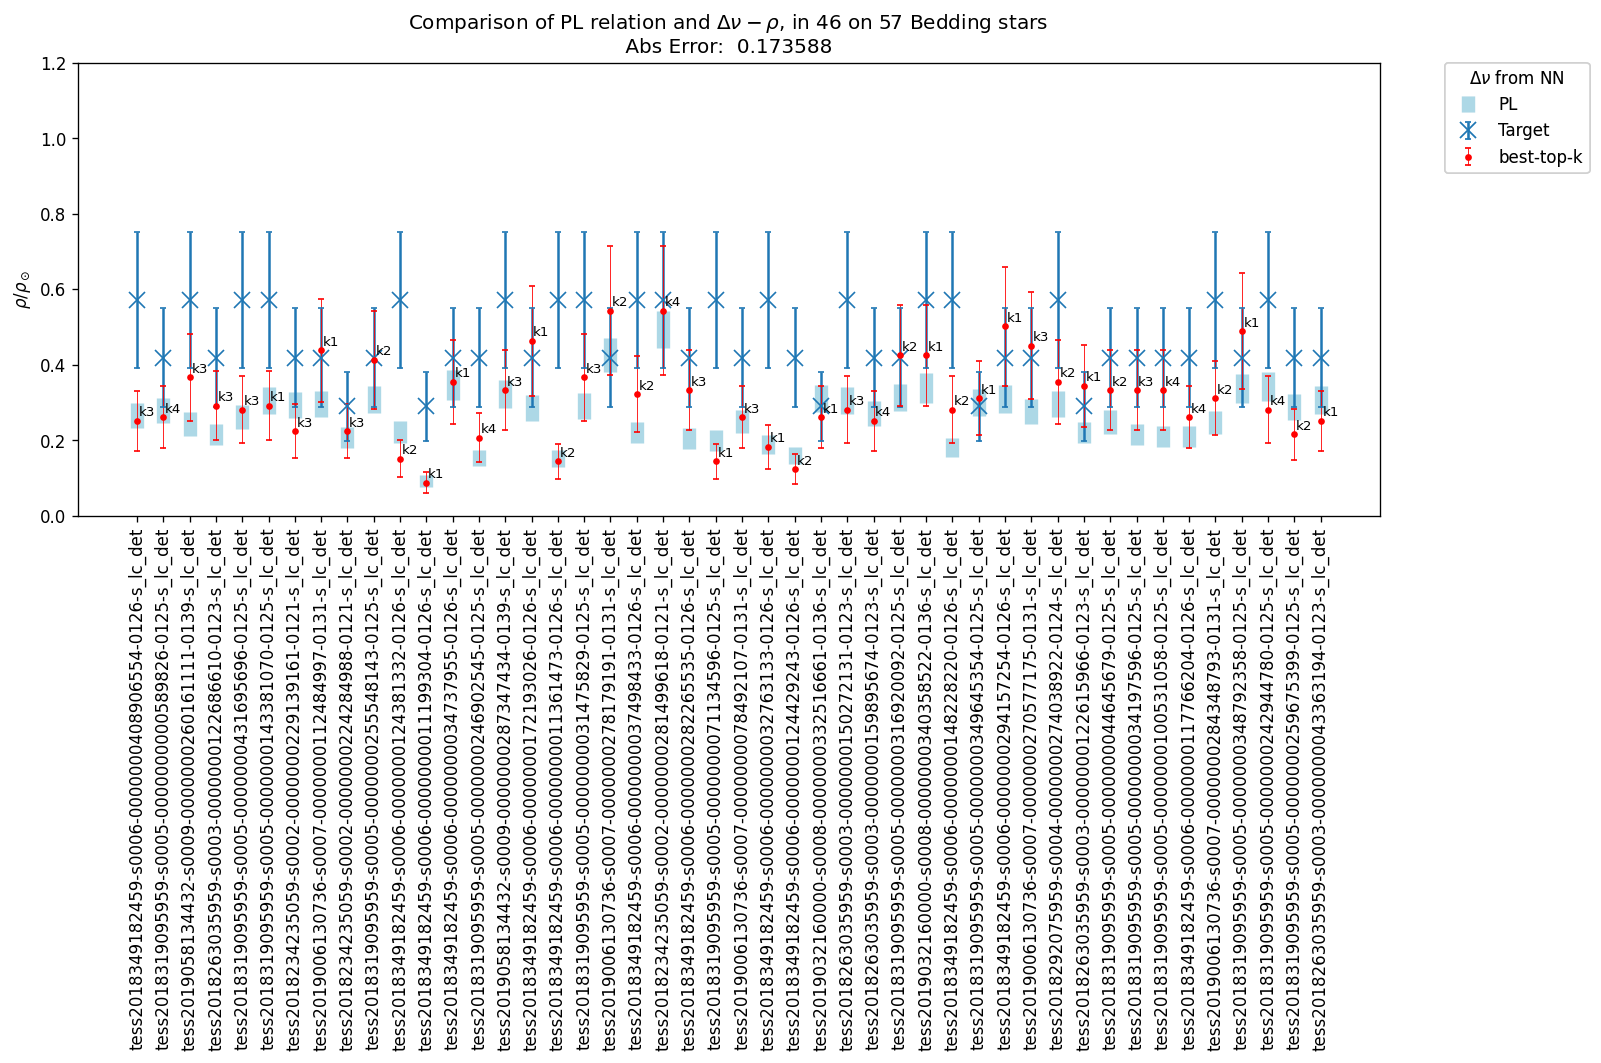

In [20]:
plt.subplots(1, figsize=(14, 5), dpi=120)
plt.errorbar(
    results_bedding["id"],
    results_bedding["rho-from-P"],
    results_bedding["e-rho-from-P"],
    elinewidth=8,
    fmt="o",
    markersize=0,
    capsize=0,
    label="PL",
    color="lightblue",
)
plt.errorbar(
    results_bedding["id"],
    results_bedding["rho-target"],
    results_bedding["e-rho-target"],
    fmt="x",
    markersize=10,
    capsize=2,
    label="Target"
)
plt.errorbar(
    results_bedding["id"],
    results_bedding["best-top"],
    results_bedding["e-best-top"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="red",
    label="best-top-k",
)
for xpos, ypos, name in zip(results_bedding["id"], results_bedding["best-top"], results_bedding["ktop"]):
    plt.annotate(name, (xpos, ypos), xytext=(1, 1), va='bottom', textcoords='offset points', size=8)
plt.xticks(rotation=90)

legend1 = plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.0,
    title=r"$\Delta\nu$ from NN",
)
plt.gca().add_artist(legend1)

plt.ylabel("$\\rho / \\rho_\\odot$")
bedding_abs_error = np.mean(np.abs(results_bedding["rho-target"] - results_bedding["best-top"]))
plt.title("Comparison of PL relation and $\Delta\\nu-\\rho$, in %d on 57 Bedding stars \n Abs Error:  %f " % (len(results_bedding), bedding_abs_error))
np.mean(np.abs(results_bedding["rho-target"] - results_bedding["best-top"]))
plt.ylim(0, 1.2)
plt.show()

## Read and process Paparó stars 

In [21]:
# Read datasets of preprocessed stars
df_cor = corot()
dfcor = df_cor.load("../../astronn/data/corot/preprocessed/*.log", batch_size=1)

In [22]:
# Preprocess 77 CoRoT stars
from astronn.preprocess import predeltascuti, precorot
if False:
    preprocessor = precorot(conf_file="../../astronn/data/corot/parameters.csv", cols=["corot", "loggs", "teff", "l"])
    preprocessor.preprocess_files(
        input_folder="../../astronn/data/corot/raw/*",
        output_folder="../../astronn/data/corot/preprocessed/",
    )

In [23]:
vrrhosun = 1.409
vrloggsun = 4.44

def get_radio_from_rho(rho, e_rho):
    """
    calculate radio from rho, estimating max and min values
    """
    R_min = (1.5 / (rho + e_rho) / vrrhosun) ** (1 / 3)
    R_max = (3 / (rho - e_rho) / vrrhosun) ** (1 / 3)
    return {"r_min": R_min, "r_max": R_max}


def get_logg_from_radio(R_max, R_min):
    """
    calculate logg from radio estimating max and min values
    """
    logg_min = np.log10(1.5 / R_max ** 2) + vrloggsun
    logg_max = np.log10(3 / R_min ** 2) + vrloggsun
    return {"logg_min": logg_min, "logg_max": logg_max}

In [24]:
# Save results and predictions
results = {}
for star in dfcor.take(75):  # take the 75 corot stars
    x_star = star[1].numpy()
    # Star logg from data
    logg_data = star[2][0].numpy()
    vrrhosun = 1.409
    target = logg_data

    # Save results
    if star[0].numpy()[0].decode("utf-8") not in results:
        results[star[0].numpy()[0].decode("utf-8")] = {
            "inference": sepconv_mod.predict_classes(star[1]),
            "target": logg_data,
        }

    probs = sepconv_mod.predict_proba(star[1])[0]
    peaks, _ = find_peaks(probs, height=0, distance=15)
    peaks_sorted_by_prob = np.sort(probs[peaks])[::-1]

    # save top-k
    results[star[0].numpy()[0].decode("utf-8")]["top-k1"] = np.where(
        probs == peaks_sorted_by_prob[0]
    )[0][0]
    results[star[0].numpy()[0].decode("utf-8")]["top-k2"] = np.where(
        probs == peaks_sorted_by_prob[1]
    )[0][0]
    results[star[0].numpy()[0].decode("utf-8")]["top-k3"] = np.where(
        probs == peaks_sorted_by_prob[2]
    )[0][0]
    results[star[0].numpy()[0].decode("utf-8")]["top-k4"] = np.where(
        probs == peaks_sorted_by_prob[3]
    )[0][0]
    results[star[0].numpy()[0].decode("utf-8")]["prob-topk1"] = probs[
        np.where(probs == peaks_sorted_by_prob[0])[0][0]
    ]
    results[star[0].numpy()[0].decode("utf-8")]["prob-topk2"] = probs[
        np.where(probs == peaks_sorted_by_prob[1])[0][0]
    ]
    results[star[0].numpy()[0].decode("utf-8")]["prob-topk3"] = probs[
        np.where(probs == peaks_sorted_by_prob[2])[0][0]
    ]
    results[star[0].numpy()[0].decode("utf-8")]["prob-topk4"] = probs[
        np.where(probs == peaks_sorted_by_prob[3])[0][0]
    ]

    # Get rho
    results[star[0].numpy()[0].decode("utf-8")]["rho-top-k1"] = get_rho(
        results[star[0].numpy()[0].decode("utf-8")]["top-k1"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["rho-top-k2"] = get_rho(
        results[star[0].numpy()[0].decode("utf-8")]["top-k2"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["rho-top-k3"] = get_rho(
        results[star[0].numpy()[0].decode("utf-8")]["top-k3"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["rho-top-k4"] = get_rho(
        results[star[0].numpy()[0].decode("utf-8")]["top-k4"] / dnu_sun
    )

    # Get errors in rho
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k1"] = rho_error(
        results[star[0].numpy()[0].decode("utf-8")]["top-k1"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k2"] = rho_error(
        results[star[0].numpy()[0].decode("utf-8")]["top-k2"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k3"] = rho_error(
        results[star[0].numpy()[0].decode("utf-8")]["top-k3"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k4"] = rho_error(
        results[star[0].numpy()[0].decode("utf-8")]["top-k4"] / dnu_sun
    )

    # Get radio and logg from rho
    results[star[0].numpy()[0].decode("utf-8")]["logg-target"] = target
    results[star[0].numpy()[0].decode("utf-8")]["e-logg-target"] = 0

    radios = get_radio_from_rho(results[star[0].numpy()[0].decode("utf-8")]["rho-top-k1"], results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k1"])
    loggs_condifence = get_logg_from_radio(radios["r_max"], radios["r_min"])
    loggs_average = (loggs_condifence["logg_max"] + loggs_condifence["logg_min"]) / 2
    results[star[0].numpy()[0].decode("utf-8")]["logg-top-k1"] = loggs_average
    results[star[0].numpy()[0].decode("utf-8")]["e-logg-top-k1"] = loggs_condifence["logg_max"]-loggs_average

    radios = get_radio_from_rho(results[star[0].numpy()[0].decode("utf-8")]["rho-top-k2"], results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k2"])
    loggs_condifence = get_logg_from_radio(radios["r_max"], radios["r_min"])
    loggs_average = (loggs_condifence["logg_max"] + loggs_condifence["logg_min"]) / 2
    results[star[0].numpy()[0].decode("utf-8")]["logg-top-k2"] = loggs_average
    results[star[0].numpy()[0].decode("utf-8")]["e-logg-top-k2"] = loggs_condifence["logg_max"]-loggs_average

    radios = get_radio_from_rho(results[star[0].numpy()[0].decode("utf-8")]["rho-top-k3"], results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k3"])
    loggs_condifence = get_logg_from_radio(radios["r_max"], radios["r_min"])
    loggs_average = (loggs_condifence["logg_max"] + loggs_condifence["logg_min"]) / 2
    results[star[0].numpy()[0].decode("utf-8")]["logg-top-k3"] = loggs_average
    results[star[0].numpy()[0].decode("utf-8")]["e-logg-top-k3"] = loggs_condifence["logg_max"]-loggs_average

    radios = get_radio_from_rho(results[star[0].numpy()[0].decode("utf-8")]["rho-top-k4"], results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k4"])
    loggs_condifence = get_logg_from_radio(radios["r_max"], radios["r_min"])
    loggs_average = (loggs_condifence["logg_max"] + loggs_condifence["logg_min"]) / 2
    results[star[0].numpy()[0].decode("utf-8")]["logg-top-k4"] = loggs_average
    results[star[0].numpy()[0].decode("utf-8")]["e-logg-top-k4"] = loggs_condifence["logg_max"]-loggs_average


    # Get L from Teff,Dnu model
    Teff = star[3][0].numpy()
    L = star[4][0].numpy()
    if not np.isnan(Teff):
        l_teff_topk1 = gam_teff_dnu.predict(np.asarray([results[star[0].numpy()[0].decode("utf-8")]["top-k1"] / dnu_sun, Teff]).reshape(1,2))[0]
        l_teff_topk2 = gam_teff_dnu.predict(np.asarray([results[star[0].numpy()[0].decode("utf-8")]["top-k2"] / dnu_sun, Teff]).reshape(1,2))[0]
        l_teff_topk3 = gam_teff_dnu.predict(np.asarray([results[star[0].numpy()[0].decode("utf-8")]["top-k3"] / dnu_sun, Teff]).reshape(1,2))[0]
        l_teff_topk4 = gam_teff_dnu.predict(np.asarray([results[star[0].numpy()[0].decode("utf-8")]["top-k4"] / dnu_sun, Teff]).reshape(1,2))[0]

        # Get L errors
        ls_teff_topks = [l_teff_topk1, l_teff_topk2, l_teff_topk3, l_teff_topk4]
        # Get L errors
        errors = [
                round(np.power(l_teff_topk1 - L, 2), 2),
                round(np.power(l_teff_topk2 - L, 2), 2),
                round(np.power(l_teff_topk3 - L, 2), 2),
                round(np.power(l_teff_topk4 - L, 2), 2),
            ]
        i = np.argmin(errors) # Get min error position
        L = ls_teff_topks[i] # Get most probable L from the model

        P = get_P(np.log10(L))
        p_e = p_error(log_L=np.log10(L))

        rho_q_up = get_rho_from_P(P-p_e, Q=0.033)
        rho_q_down = get_rho_from_P(P+p_e, Q=0.042)

        radios = get_radio_from_rho((rho_q_up+rho_q_down)/2, rho_q_up-((rho_q_up+rho_q_down)/2))
        loggs_condifence = get_logg_from_radio(radios["r_max"], radios["r_min"])
        loggs_average = (loggs_condifence["logg_max"] + loggs_condifence["logg_min"]) / 2
        results[star[0].numpy()[0].decode("utf-8")]["logg-from-P-fromstarmodel"] = loggs_average
        results[star[0].numpy()[0].decode("utf-8")]["e-logg-from-P-fromstarmodel"] = loggs_condifence["logg_max"] - loggs_average
    else:
        results[star[0].numpy()[0].decode("utf-8")]["logg-from-P-fromstarmodel"] = np.nan
        results[star[0].numpy()[0].decode("utf-8")]["e-logg-from-P-fromstarmodel"] = np.nan

    # Get P from L
    L = star[4][0].numpy()

    # Check for non L in csv or NaN value
    if not np.isnan(L):
        P = get_P(np.log10(L))
        p_e = p_error(log_L=np.log10(L))
        #p_e=0

        rho_q_up = get_rho_from_P(P+p_e, Q=0.033)
        rho_q_down = get_rho_from_P(P-p_e, Q=0.042)
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-up"] = rho_q_up
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-down"] = rho_q_down

        radios = get_radio_from_rho((rho_q_up+rho_q_down)/2, rho_q_up-((rho_q_up+rho_q_down)/2))
        loggs_condifence = get_logg_from_radio(radios["r_max"], radios["r_min"])
        loggs_average = (loggs_condifence["logg_max"] + loggs_condifence["logg_min"]) / 2
        results[star[0].numpy()[0].decode("utf-8")]["logg-from-P"] = loggs_average
        results[star[0].numpy()[0].decode("utf-8")]["e-logg-from-P"] = loggs_condifence["logg_max"] - loggs_average

    else:
        print(star[0].numpy()[0].decode("utf-8"))
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-up"] = np.nan
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-down"] = np.nan
        results[star[0].numpy()[0].decode("utf-8")]["logg-from-P"] = np.nan
        results[star[0].numpy()[0].decode("utf-8")]["e-logg-from-P"] = np.nan

In [25]:
df = pd.DataFrame(
    columns=[
        "id",
        "logg-target",
        "e-logg-target",
        "logg-top-k1",
        "e-logg-top-k1",
        "logg-top-k2",
        "e-logg-top-k2",
        "logg-top-k3",
        "e-logg-top-k3",
        "logg-top-k4",
        "e-logg-top-k4",
        "rho-top-k1",
        "e-rho-top-k1",
        "rho-top-k2",
        "e-rho-top-k2",
        "rho-top-k3",
        "e-rho-top-k3",
        "rho-top-k4",
        "e-rho-top-k4",
        "rho-from-P-up",
        "rho-from-P-down",
        "logg-from-P",
        "e-logg-from-P",
        "logg-from-P-fromstarmodel",
        "e-logg-from-P-fromstarmodel"
    ]
)
for i, id in enumerate(results):
    df.loc[i] = [
        id,
        results[id]["logg-target"],
        results[id]["e-logg-target"],
        results[id]["logg-top-k1"],
        results[id]["e-logg-top-k1"],
        results[id]["logg-top-k2"],
        results[id]["e-logg-top-k2"],
        results[id]["logg-top-k3"],
        results[id]["e-logg-top-k3"],
        results[id]["logg-top-k4"],
        results[id]["e-logg-top-k4"],
        results[id]["rho-top-k1"],
        results[id]["e-rho-top-k1"],
        results[id]["rho-top-k2"],
        results[id]["e-rho-top-k2"],
        results[id]["rho-top-k3"],
        results[id]["e-rho-top-k3"],
        results[id]["rho-top-k4"],
        results[id]["e-rho-top-k4"],
        results[id]["rho-from-P-up"],
        results[id]["rho-from-P-down"],
        results[id]["logg-from-P"],
        results[id]["e-logg-from-P"],
        results[id]["logg-from-P-fromstarmodel"],
        results[id]["e-logg-from-P-fromstarmodel"]
    ]
df

,id,logg-target,e-logg-target,logg-top-k1,e-logg-top-k1,logg-top-k2,e-logg-top-k2,logg-top-k3,e-logg-top-k3,logg-top-k4,...,rho-top-k3,e-rho-top-k3,rho-top-k4,e-rho-top-k4,rho-from-P-up,rho-from-P-down,logg-from-P,e-logg-from-P,logg-from-P-fromstarmodel,e-logg-from-P-fromstarmodel
0,102642516,3.700,0,3.963181,0.346291,4.275899,0.345154,4.410525,0.344831,3.590566,...,0.463509,0.145372,0.027403,0.008892,0.130596,0.442080,4.235287,0.074335,3.245851,0.339415
1,102686153,3.525,0,3.945696,0.346371,3.352880,0.350015,4.295743,0.345100,4.426343,...,0.311898,0.098083,0.489520,0.153482,0.086086,0.301343,4.119473,0.069482,3.278135,0.337438
2,102600012,4.400,0,4.342593,0.344981,4.140195,0.345582,4.485652,0.344695,4.582851,...,0.600737,0.188156,0.840278,0.262845,0.255857,0.825668,4.423077,0.081256,3.100707,0.348484
3,102677987,3.950,0,4.012703,0.346076,4.234068,0.345275,3.521532,0.348793,4.464110,...,0.021601,0.007040,0.557684,0.174734,0.081625,0.287008,4.104714,0.068834,3.156958,0.344934
4,102637079,3.850,0,3.849455,0.346837,4.200606,0.345379,3.352880,0.350015,4.426343,...,0.012081,0.003983,0.489520,0.153482,0.203269,0.666149,4.358691,0.079025,3.235373,0.340059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,102694610,3.700,0,3.708162,0.347611,4.012703,0.346076,4.234068,0.345275,2.539439,...,0.252105,0.079417,0.000734,0.000260,0.100569,0.347556,4.162640,0.071339,3.096486,0.348753
71,102688156,4.400,0,4.570788,0.344579,4.100706,0.345725,4.402453,0.344847,3.557066,...,0.450773,0.141401,0.024415,0.007939,0.151017,0.505602,4.275754,0.075931,3.153414,0.345157
72,102639464,3.900,0,4.410525,0.344831,4.255357,0.345212,4.570788,0.344579,3.980158,...,0.805999,0.252155,0.104994,0.033382,NaN,NaN,NaN,NaN,3.039428,0.352401
73,102724195,3.900,0,3.806040,0.347064,4.100706,0.345725,4.275899,0.345154,4.485652,...,0.291253,0.091640,0.600737,0.188156,0.320588,1.020112,4.486341,0.083291,3.188491,0.342963


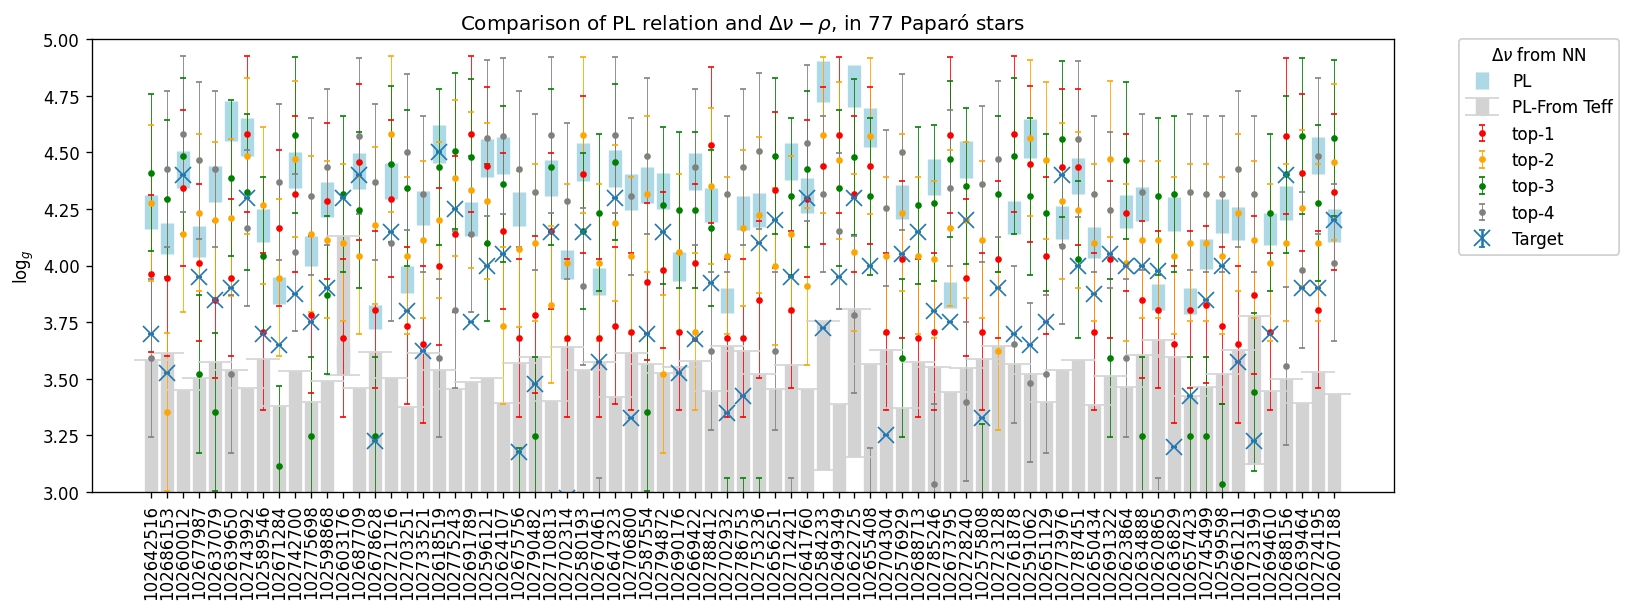

In [26]:
plt.subplots(1, figsize=(14, 5), dpi=120)

#plt.scatter(df["id"], df["rho-from-file"], color="black", label="rho Bedding", s=90)

plt.errorbar(
    df["id"],
    df["logg-from-P"],
    df["e-logg-from-P"],
    elinewidth=8,
    fmt="o",
    markersize=0,
    capsize=0,
    label="PL",
    color="lightblue",
)

plt.errorbar(
    df["id"],
    df["logg-from-P-fromstarmodel"],
    df["e-logg-from-P-fromstarmodel"],
    elinewidth=8,
    fmt="o",
    markersize=0,
    capsize=10,
    label="PL-From Teff",
    color="lightgrey",
)

p1,p1,p1 = plt.errorbar(
    df["id"],
    df["logg-top-k1"],
    df["e-logg-top-k1"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="red",
    label="top-1",
)
p2,_,_ = plt.errorbar(
    df["id"],
    df["logg-top-k2"],
    df["e-logg-top-k2"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="orange",
    label="top-2",
)
p3,_,_ = plt.errorbar(
    df["id"],
    df["logg-top-k3"],
    df["e-logg-top-k3"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="green",
    label="top-3",
)
p4,_,_ = plt.errorbar(
    df["id"],
    df["logg-top-k4"],
    df["e-logg-top-k4"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="grey",
    label="top-4",
)

p6,_,_ = plt.errorbar(
    df["id"],
    df["logg-target"],
    df["e-logg-target"],
    fmt="x",
    markersize=10,
    capsize=2,
    label="Target",
)

plt.xticks(rotation=90)

legend1 = plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.0,
    title=r"$\Delta\nu$ from NN",
)
plt.gca().add_artist(legend1)

plt.ylabel("$\log_g$")
plt.title("Comparison of PL relation and $\Delta\\nu-\\rho$, in 77 Paparó stars")
plt.ylim(3, 5)
plt.show()